# Finetune an Image Classification Transformer Model

This notebook demonstrates the process of fine-tuning a pre-trained Vision Transformer (ViT) model for image classification. The goal is to adapt the model to correctly classify images of bean leaves into three categories: angular_leaf_spot, bean_rust, and healthy.

The workflow is organized into several key steps:
- Data Preparation: Load and preprocess the bean dataset by resizing and normalizing the images using a ViT image processor.
- Model Configuration: Load a pre-trained ViT model and adjust its classification head to match the number of classes in the dataset.
- Training Setup: Define training parameters, including batch sizes, epochs, and evaluation metrics.
- Fine-tuning: Train the model on the bean dataset.
- Evaluation: Compare metrics on a dedicated test set before and after fine-tuning to assess model improvement.

This structured approach ensures reproducibility and facilitates experimentation with different configurations.



In [1]:
# Step 1: Install and import dependencies
! pip install transformers datasets pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import numpy as np

## Step 2: Load and prepare data

This dataset, called the `beans` dataset, consists of images of bean leaves categorized into three classes:        `angular_leaf_spot`, `bean_rust`, and `healthy`.

It is divided into training (1034 samples), validation (133 samples), and test (128 samples) sets. Each example includes an image and its corresponding label, making it suitable for image classification tasks. The images are pre-processed using a ViTImageProcessor to ensure consistent sizing (224x224) and normalization, preparing the data effectively for training a Vision Transformer model.

In [3]:
dataset = load_dataset("beans")
label_names = dataset['train'].features['labels'].names
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

def transform(examples):
    inputs = processor(examples['image'], return_tensors="pt")
    inputs['labels'] = examples['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]


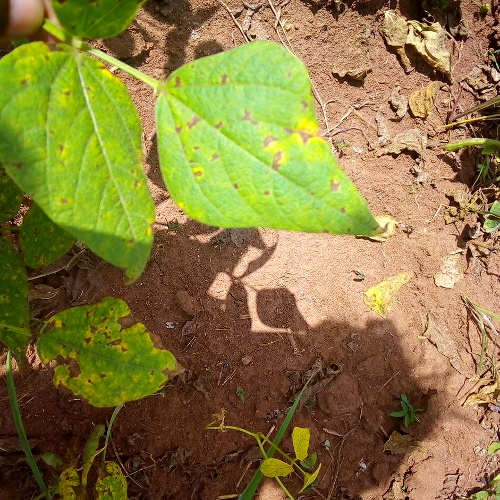
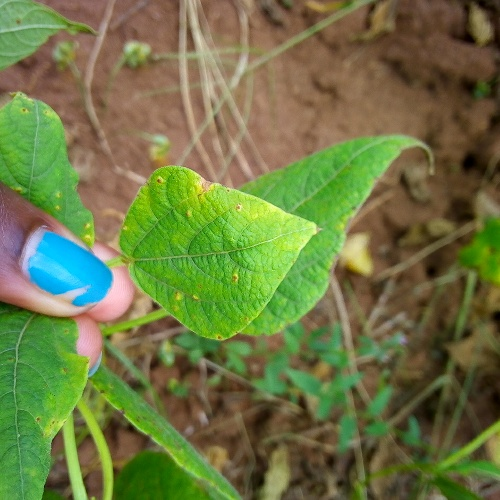
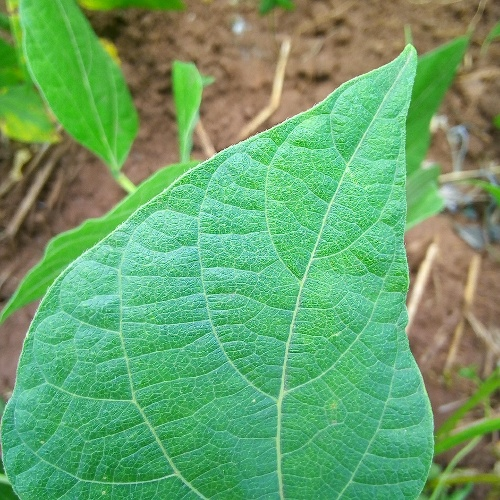

In [4]:
from IPython.display import display, HTML
import io
import base64

def image_to_base64(img):
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

# Display one image from each label in the test set
rows = []
for i, label in enumerate(label_names):
    filtered = dataset['train'].filter(lambda x: x['labels'] == i)
    if len(filtered) > 0:
        example = filtered[0]
        img = example['image']
        img_b64 = image_to_base64(img)
        img_html = f"<img src='data:image/png;base64,{img_b64}' width='100'/>"
        rows.append((img_html, label))

table_html = "<table style='border-collapse: collapse;'>"
table_html += "<tr><th style='border: 1px solid black; padding: 5px;'>Image</th><th style='border: 1px solid black; padding: 5px;'>Label</th></tr>"
for img_html, label in rows:
    table_html += f"<tr><td style='border: 1px solid black; padding: 5px;'>{img_html}</td><td style='border: 1px solid black; padding: 5px; text-align: center;'>{label}</td></tr>"
table_html += "</table>"

display(HTML(table_html))

## Step 3: Load model and define training configuration

We load a pre-trained Vision Transformer model for image classification by specifying the number of labels using the length of label_names. We then create training arguments that set the output directory, evaluation and saving strategies, batch sizes, epochs, and logging frequency. A compute_metrics function is defined to calculate the accuracy by comparing the model's predictions with the true labels. Finally, we instantiate a Trainer object with the model, training arguments, prepared training and validation datasets, the image processor acting as the tokenizer, and the accuracy computation function.

In [5]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(label_names),
    ignore_mismatched_sizes=True
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_steps=10,
    weight_decay=0.01,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds['train'],
    eval_dataset=prepared_ds['validation'],
    tokenizer=processor,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-db5cfbdcf551>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Evaluate model before training


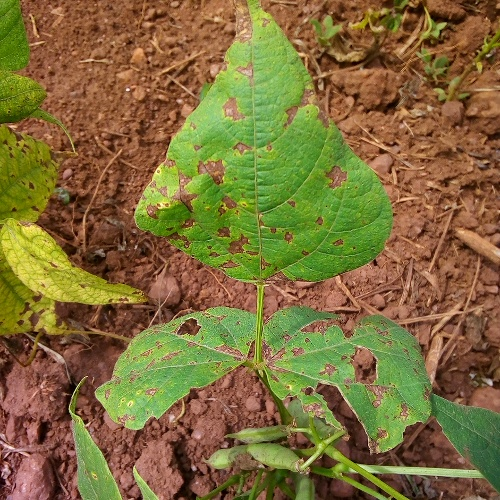
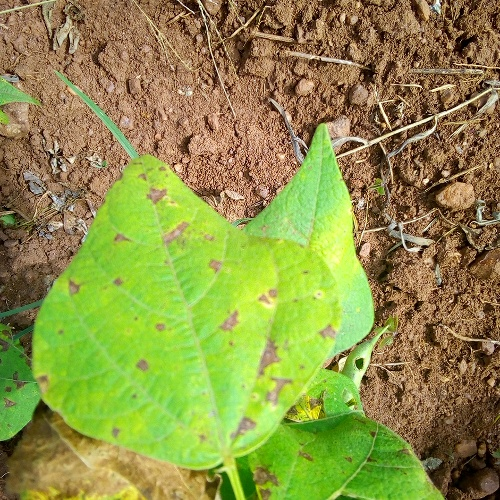
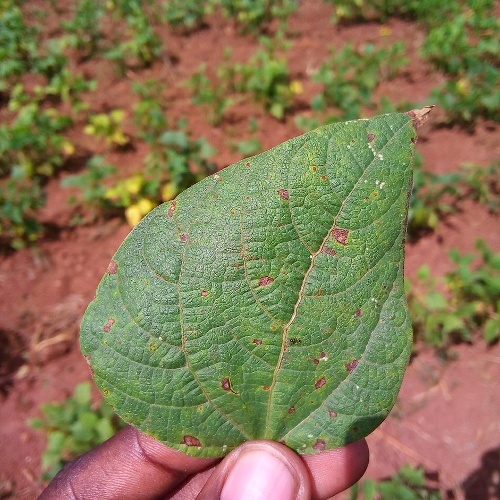
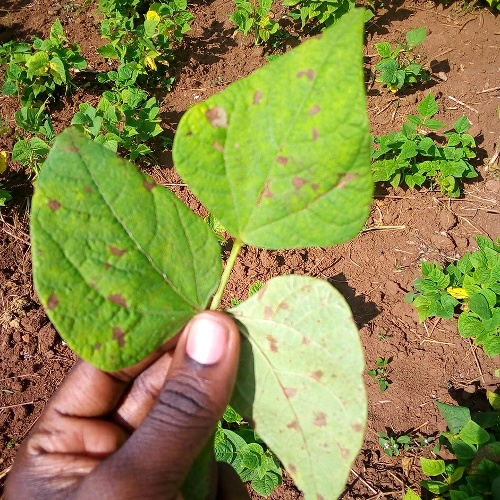
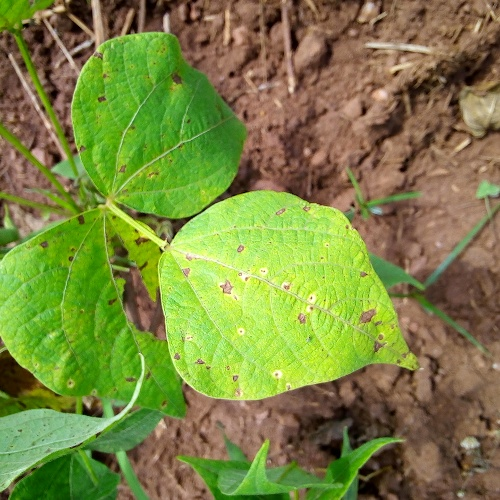

In [6]:
import pandas as pd
from IPython.display import HTML

metrics_before = trainer.evaluate(prepared_ds['test'])

# Create a predictions table for 5 samples from the test set
subset = dataset['test'].select([0,10,30,40,50])
prepared_subset = subset.with_transform(transform)
pred_out = trainer.predict(prepared_subset)
pred_labels = np.argmax(pred_out.predictions, axis=1)
true_labels = pred_out.label_ids

pred_names = [label_names[i] for i in pred_labels]
true_names = [label_names[i] for i in true_labels]

# Add images column by converting each sample image using the image_to_base64 utility function
images = []
for sample in subset:
    img_b64 = image_to_base64(sample['image'])
    img_html = f"<img src='data:image/png;base64,{img_b64}' width='100'/>"
    images.append(img_html)

df_preds = pd.DataFrame({
    "Image": images,
    "Prediction": pred_names,
    "True Label": true_names
})

display(HTML(df_preds.to_html(escape=False)))

## Step 4: Train the model

In [7]:
trainer.train()

TrainOutput(global_step=130, training_loss=0.22933630908911046, metrics={'train_runtime': 65.5779, 'train_samples_per_second': 15.768, 'train_steps_per_second': 1.982, 'total_flos': 8.012743541191066e+16, 'train_loss': 0.22933630908911046, 'epoch': 1.0})

## Step 5: Evaluate on the test set

In [8]:
import pandas as pd
metrics_after = trainer.evaluate(prepared_ds['test'])
metrics_table = pd.DataFrame([metrics_before, metrics_after],
                               index=["Before Training", "After Training"])
metrics_table

eval_loss  eval_model_preparation_time  eval_accuracy  \
Before Training   1.091740                       0.0045       0.390625   
After Training    0.067253                       0.0045       0.953125   

                 eval_runtime  eval_samples_per_second  eval_steps_per_second  \
Before Training        3.5854                   35.701                  4.463   
After Training         4.0548                   31.567                  3.946   

                 epoch  
Before Training    NaN  
After Training     1.0


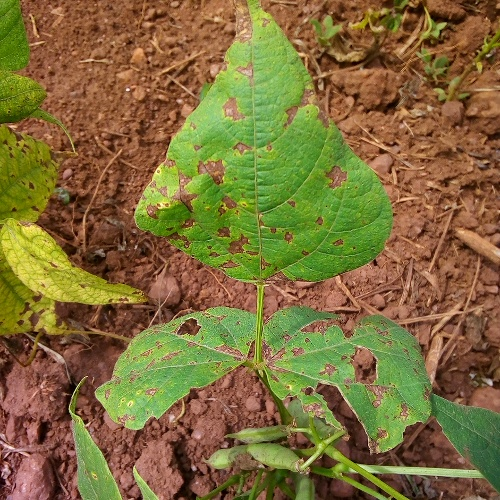
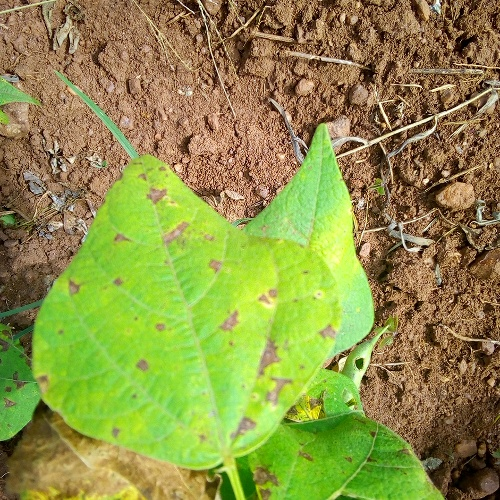
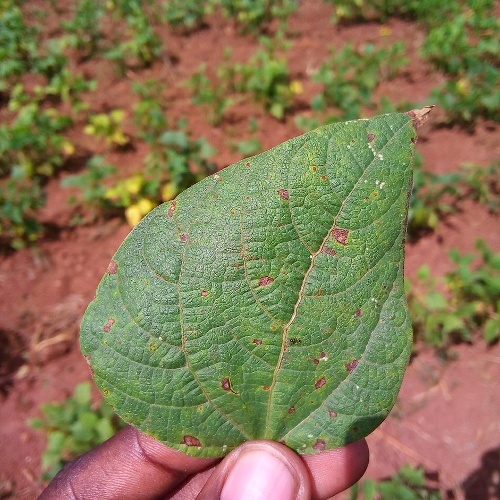
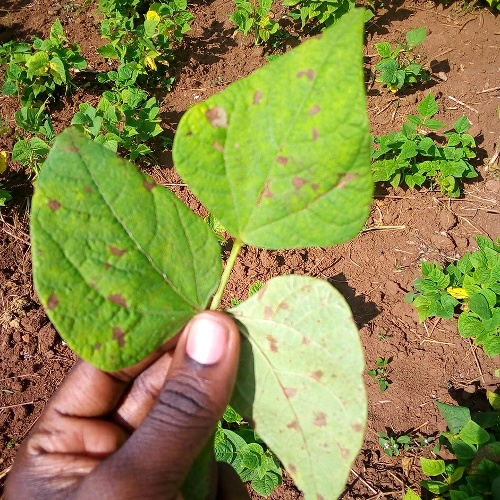
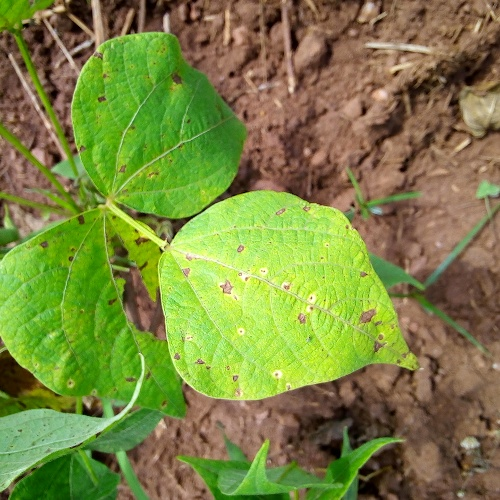

In [9]:
# Create a predictions table for 5 samples from the test set
subset = dataset['test'].select([0,10,30,40,50])
prepared_subset = subset.with_transform(transform)
pred_out = trainer.predict(prepared_subset)
pred_labels = np.argmax(pred_out.predictions, axis=1)
true_labels = pred_out.label_ids

pred_names = [label_names[i] for i in pred_labels]
true_names = [label_names[i] for i in true_labels]

# Add images column by converting each sample image using the image_to_base64 utility function
images = []
for sample in subset:
    img_b64 = image_to_base64(sample['image'])
    img_html = f"<img src='data:image/png;base64,{img_b64}' width='100'/>"
    images.append(img_html)

df_preds = pd.DataFrame({
    "Image": images,
    "Prediction": pred_names,
    "True Label": true_names
})

display(HTML(df_preds.to_html(escape=False)))